# Import Libraries

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from IPython import display
import seaborn as sn
import pandas as pd
import torch

# Check the availablity of GPU

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Read the data

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Time Series Transformer

/content/drive/MyDrive/Course Material/Supervised Machine Learning/Time Series Transformer


In [13]:
normal = pd.read_csv('ptbdb_normal.csv',header = None)
abnormal = pd.read_csv('ptbdb_abnormal.csv', header = None)

In [14]:
print(normal.shape)
print(" ")
print(abnormal.shape)

(4046, 188)
 
(10506, 188)


In [15]:
normal[187].value_counts()

187
0.0    4046
Name: count, dtype: int64

In [16]:
abnormal[187].value_counts()

187
1.0    10506
Name: count, dtype: int64

# Concatenate both components to make a single dataset

In [17]:
data = pd.concat([normal, abnormal])

In [18]:
data.shape

(14552, 188)

# Check if the data is balanced

In [19]:
data[187].value_counts()

187
1.0    10506
0.0     4046
Name: count, dtype: int64

<Axes: >

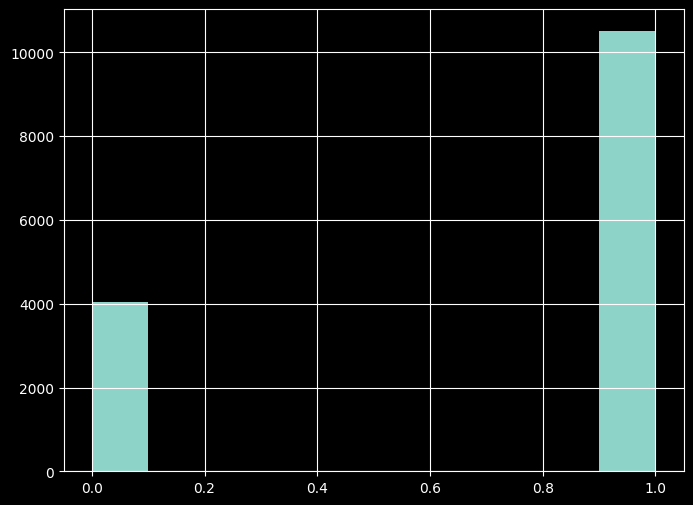

In [21]:
plt.figure(figsize = (8,6))
data[187].hist()

In [22]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Extract feature and labels

In [23]:
X = data[data.columns[0:-1]].values
y = data[data.columns[-1]].values

# Perform train-test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform to tensor and using Dataloader

In [27]:
# Convert to tensor
train_data = torch.tensor(X_train)
train_labels = torch.tensor(y_train).long()
test_data = torch.tensor(X_test)
test_labels = torch.tensor(y_test).long()

# Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=batchsize, drop_last=True)

In [28]:
for X, y in train_loader:
    break
print(X.shape)

torch.Size([32, 187])


# Creating the Transformer Model

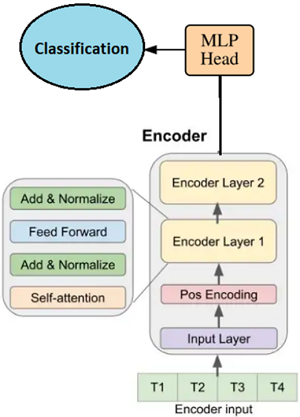

In [29]:
model = nn.Sequential(
          nn.Linear(187,256),
          nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model = 256, nhead  = 8), num_layers = 6),
          nn.Linear(256,128),
          nn.Linear(128,64),
          nn.Linear(64,2),
          )

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [30]:
model

Sequential(
  (0): Linear(in_features=187, out_features=256, bias=True)
  (1): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Linear(in_features=64, out_features=2, bias=True)
)

# Setting Early Stopping Criterion

In [31]:
class EarlyStoppingCriterion():
    def __init__(self, patience = 7, delta = 0,  trace_func = print):

        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Training and Testing the Model

In [ ]:
  numepochs = 100
  n_classes = 2
  model.to(device)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

# Instantiating the early stopping
  earlystopping = EarlyStoppingCriterion()


  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  test_loss = []

  for epoch in range(numepochs):
    model.train()

    # loop over training batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      ypred = model(X.float())
      loss = lossfun(ypred,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      ypred = ypred.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(ypred,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )


    # Average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # Average losses across the batches
    losses[epoch] = np.mean(batchLoss)

    # test the model

    model.eval()

    with torch.no_grad(): # deactivates autograd
     batchAcc_test = []
     y_pred = np.zeros((X_test.shape[0] // batchsize , batchsize, n_classes))
     y_true = np.zeros((X_test.shape[0] // batchsize , batchsize))
     testbatch_losses = [] # This is new calculation

     for idx, (X,y) in enumerate(test_loader):

      X = X.to(device)
      y = y.to(device)
      ypred_t = model(X.float())
      ypred_t = ypred_t.cpu()
      y_pred[idx,:,:] = ypred_t
      y = y.cpu()
      y_true[idx,:] = y
      tloss = lossfun(ypred_t, y)
      # record test loss
      testbatch_losses.append(tloss.item())

      matches = torch.argmax(ypred_t,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc_test.append( accuracyPct )
    test_loss.append(np.mean(testbatch_losses) )
    testAcc.append( np.mean(batchAcc_test) )
    epoch_len = len(str(numepochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{numepochs:>{epoch_len}}] ' +

                     f'test_loss: {np.mean(testbatch_losses):.5f}')

    print(print_msg)

    earlystopping(np.mean(testbatch_losses), model)

    if earlystopping.early_stop:
        print("Early stopping")
        break

[  0/100] test_loss: 0.40234
[  1/100] test_loss: 0.37551
[  2/100] test_loss: 0.30813
[  3/100] test_loss: 0.28865
[  4/100] test_loss: 0.28092
[  5/100] test_loss: 0.27133
[  6/100] test_loss: 0.24769
[  7/100] test_loss: 0.24316
[  8/100] test_loss: 0.22144
[  9/100] test_loss: 0.19954
[ 10/100] test_loss: 0.19984
EarlyStopping counter: 1 out of 7
[ 11/100] test_loss: 0.19944
[ 12/100] test_loss: 0.17825
[ 13/100] test_loss: 0.14508
[ 14/100] test_loss: 0.16362
EarlyStopping counter: 1 out of 7
[ 15/100] test_loss: 0.15645
EarlyStopping counter: 2 out of 7
[ 16/100] test_loss: 0.13687
[ 17/100] test_loss: 0.12484
[ 18/100] test_loss: 0.12288
[ 19/100] test_loss: 0.13286
EarlyStopping counter: 1 out of 7
[ 20/100] test_loss: 0.12123
[ 21/100] test_loss: 0.11906
[ 22/100] test_loss: 0.12181
EarlyStopping counter: 1 out of 7
[ 23/100] test_loss: 0.10210
[ 24/100] test_loss: 0.10004
[ 25/100] test_loss: 0.11453
EarlyStopping counter: 1 out of 7
[ 26/100] test_loss: 0.09597
[ 27/100] tes

# Visualize Model Performance

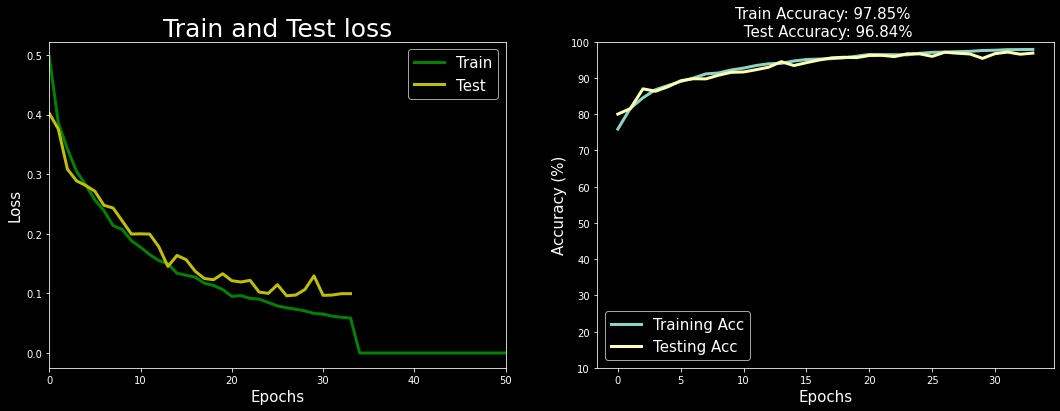

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].plot(test_loss,'y', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].set_xlim([0,50])
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Train and Test loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()